# Amplitude coupling

## Import zone

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as ct
import pandas as pd
import warnings

from scipy.optimize import curve_fit
from functools import partial
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle, ConnectionPatch
from matplotlib.ticker import ScalarFormatter

from src.systems.linear_traps import ThreeRFTrap
from src.io.loading import load_threeRF_geometry
from src.geometry.geometry_utils import check_all_ccw

## Load trap geometry

In [2]:
geometry = load_threeRF_geometry("RF_params.json")

# Trench width
trench_width = 5

# Set segmentation flags
flags = {
    "build_outer_RF": True,
    "build_central_RF": True,
}

# Build trap
trap = ThreeRFTrap(geometry, trench_width, flags)
system = trap.build()

check_all_ccw(system)

All electrodes are CCW.


## Build whole system

In this part we build the whole system and then we compute the minima positions, the value of the pseudopotential as the RF ratio changes and the secular frequencies

In [3]:
csi_values = np.linspace(-1., 1.5, 1001)
csi_values[csi_values == 0] = 1e-12
x0 = (0., 0., 350.)
x1 = (0., 0., 10.)
minimum_positions_0 = []
minimum_positions_1 = []
pot_values_0 = []
pot_values_1 = []
secular_frequencies = []

L = 1e-6 # um length scale
M = 40 * ct.atomic_mass # ion mass (calcium)
Q = 1 * ct.elementary_charge # ion charge (single-ion)
Omega = 2 * np.pi * 19e6
V0 = 100

scale = Q / (2 * Omega * np.sqrt(M))

for csi in csi_values:
    voltages = {
        "central_RF": {"attr": "rf", "value": csi},
        "outer_RF": {"attr": "rf", "value": 1},
    }

    system = trap.build(voltages)

    try:
        if csi > 0.75:
            x0[0] -= 1
            x1[0] += 1
        x0 = system.minimum(x0=(x0[0], x0[1], x0[2]), axis=(0,2), coord=np.identity(3), method="Powell")
        minimum_positions_0.append(x0)
        pot_values_0.append(scale**2 * system.potential(x=x0, derivative=0)[0] * (V0/L)**2)

        if csi > 0.16:
            x1 = system.minimum(x0=(x1[0], x1[1], x1[2]), axis=(0,2), coord=np.identity(3), method="Powell")
            pot_values_1.append(scale**2 * system.potential(x=x1, derivative=0)[0] * (V0/L)**2)
            minimum_positions_1.append(x1)
            
        # Compute secular frequencies
        curve_z = system.modes(x0)
        omega_sec = np.sqrt(abs(curve_z[0]) / M * (scale * V0 / L**2)**2)
        secular_frequencies.append(omega_sec)
    except:
        print(csi, "minimum not found")

/home/kallo27/anaconda3/lib/python3.11/site-packages/electrode-1.5+dev-py3.11-linux-x86_64.egg/electrode/system.py:439: RuntimeWarning: Method Powell does not use gradient information (jac).
  res = optimize.minimize(fun=f, x0=x0, jac=g, hess=h,
/home/kallo27/anaconda3/lib/python3.11/site-packages/electrode-1.5+dev-py3.11-linux-x86_64.egg/electrode/system.py:439: RuntimeWarning: Method Powell does not use Hessian information (hess).
  res = optimize.minimize(fun=f, x0=x0, jac=g, hess=h,


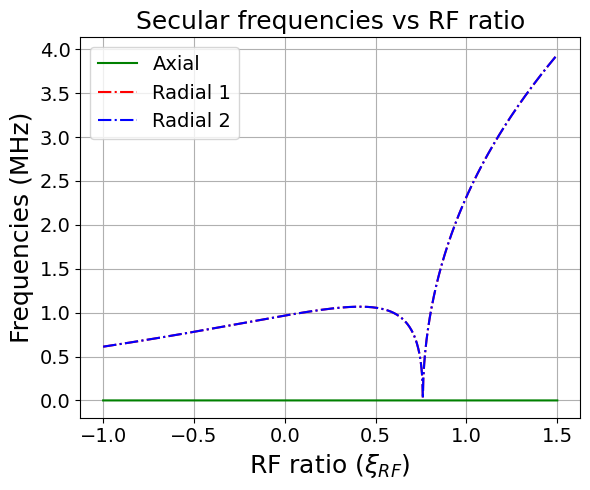

In [4]:
# Convert to arrays for slicing
sec_0 = np.array(secular_frequencies)[:,0]/(2*np.pi)/1e6
sec_1 = np.array(secular_frequencies)[:,1]/(2*np.pi)/1e6
sec_2 = np.array(secular_frequencies)[:,2]/(2*np.pi)/1e6

sec = [sec_1, sec_0, sec_2]

# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 5))

# Plot z and x components for both datasets
ax.plot(csi_values, sec_0, label='Axial', color='green', linestyle='-')
ax.plot(csi_values, sec_1, label='Radial 1', color='red', linestyle='-.')
ax.plot(csi_values, sec_2, label='Radial 2', color='blue', linestyle='-.')

# Add labels and grid
ax.set_xlabel(r"RF ratio $(\xi_{{RF}})$", fontsize=18)
ax.set_ylabel('Frequencies (MHz)', fontsize=18)
ax.set_title('Secular frequencies vs RF ratio', fontsize=18)
ax.grid(True)
ax.legend(fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()
plt.show()

## Load experimental data

In [5]:
df = pd.read_excel("heating rate data.xlsx")

csi_exp = df.iloc[:, 0].values
h_exp = df.iloc[:, 1].values
error_h_exp = df.iloc[:, 2].values
freq_exp = df.iloc[:, 3].values

# Find corresponding indices
indices = []
for csi in csi_exp:
    idx = np.where(np.isclose(csi_values, np.round(csi, 2)))[0]
    if len(idx) == 0:
        raise ValueError(f"csi value {csi} not found in csi_values!")
    indices.append(idx[0])
indices = np.array(indices)

# Rescale y_data
for i in range(len(h_exp)):
    scale_factor = freq_exp[i] / sec_1[indices][i]
    h_exp[i] *= scale_factor
    error_h_exp[i] *= scale_factor  # Scale error accordingly

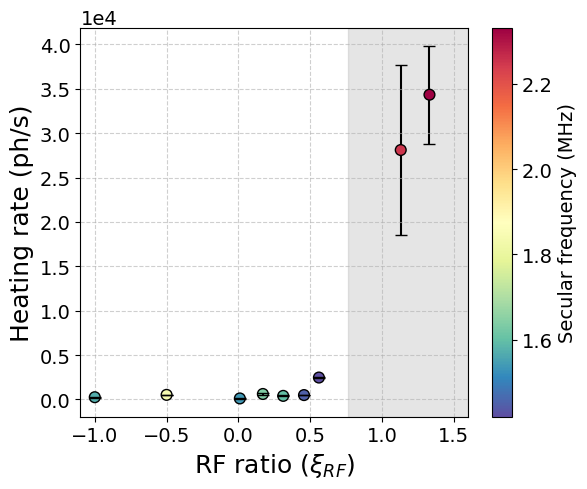

In [6]:
# Create the figure
plt.figure(figsize=(6, 5))

# Error bars in front (small errors)
plt.errorbar(
    csi_exp[:7],
    h_exp[:7],
    yerr=error_h_exp[:7],
    fmt='none',
    ecolor='black',
    capsize=4,
    zorder=3
)

# Error bars behind (large errors)
plt.errorbar(
    csi_exp[7:],
    h_exp[7:],
    yerr=error_h_exp[7:],
    fmt='none',
    ecolor='black',
    capsize=4,
    zorder=1
)

# Overlay colored scatter plot
sc = plt.scatter(
    csi_exp,
    h_exp,
    c=freq_exp,
    cmap='Spectral_r',  # You can choose another colormap
    s=60,            # Marker size
    edgecolor='black',
    zorder=2,
    label='Experimental data'
)

# Labels and formatting
plt.xlabel(r"RF ratio $(\xi_{{RF}})$", fontsize=18)
plt.ylabel('Heating rate (ph/s)', fontsize=18)
#plt.title('Heating rate vs RF Ratio', fontsize=18)
plt.xlim(-1.1, 1.6)
plt.grid(True, linestyle='--', alpha=0.6, zorder=0)

# Add colorbar
cbar = plt.colorbar(sc)
cbar.set_label('Secular frequency (MHz)', fontsize=14)

# Use scientific notation on both axes
ax = plt.gca()
ax.ticklabel_format(style='sci', axis='both', scilimits=(0, 0))
ax.yaxis.offsetText.set_fontsize(14)

# Set tick label font sizes
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
cbar.ax.tick_params(labelsize=14)
cbar.ax.yaxis.offsetText.set_fontsize(14)

min_index = np.argmin(sec_0)  # index of minimum y
csi_at_min = csi_values[min_index]

plt.axvspan(csi_at_min, plt.xlim()[1], color='gray', alpha=0.2, zorder=0)
plt.tight_layout()
plt.show()

## Compute gradient components

In [7]:
gradient_with_noise_O = []
gradient_without_noise_O = []
gradient_with_noise_I = []
gradient_without_noise_I = []
grad_E_O_values = []
grad_E_I_values = []
E_O_values = []
E_I_values = []
mixed_terms = []

flags_outer = {"build_central_RF": False}
flags_central = {"build_outer_RF": False}

for i in range(len(csi_values)):
    voltages_outer = {"outer_RF": {"attr": "rf", "value": 1}}
    voltages_central = {"central_RF": {"attr": "rf", "value": csi_values[i]}}
    
    system_outer = trap.build(voltages_outer, flags_outer)
    system_central = trap.build(voltages_central, flags_central)
    
    try:
        grad_E_O = -system_outer.electrical_potential(x=minimum_positions_0[i], typ="rf", derivative=2, expand=True)[0] * (V0 / L**2)
        grad_E_O_values.append(grad_E_O)
        E_O = -system_outer.electrical_potential(x=minimum_positions_0[i], typ="rf", derivative=1)[0] * (V0 / L)
        E_O_values.append(E_O)
        
        grad_E_I = -system_central.electrical_potential(x=minimum_positions_0[i], typ="rf", derivative=2, expand=True)[0] * (V0 / L**2)
        grad_E_I_values.append(grad_E_I)
        E_I = -system_central.electrical_potential(x=minimum_positions_0[i], typ="rf", derivative=1)[0] * (V0 / L)
        E_I_values.append(E_I)

        gradient_with_noise_O.append(2*np.einsum("i, ij -> j", E_O, grad_E_O) + np.einsum("i, ij -> j", E_O, grad_E_I) 
                                     + np.einsum("i, ij -> j", E_I, grad_E_O))
        gradient_with_noise_I.append(2*np.einsum("i, ij -> j", E_I, grad_E_I) + np.einsum("i, ij -> j", E_O, grad_E_I) 
                                     + np.einsum("i, ij -> j", E_I, grad_E_O))
        gradient_without_noise_O.append(2*np.einsum("i, ij -> j", E_O, grad_E_O))
        gradient_without_noise_I.append(2*np.einsum("i, ij -> j", E_I, grad_E_I))
        
    except:
        print(csi_values[i], "grad(phi) not found")

/home/kallo27/thesis/src/systems/linear_traps.py:231: UserWarning: Flag 'build_central_RF' is False, but RF geometry is provided.
  warnings.warn("Flag 'build_central_RF' is False, but RF geometry is provided.")
/home/kallo27/thesis/src/systems/linear_traps.py:235: UserWarning: Flag 'build_outer_RF' is False, but RF geometry is provided.
  warnings.warn("Flag 'build_outer_RF' is False, but RF geometry is provided.")


In [8]:
def build_rotation_matrix(theta_rad, axis0, axis1):
    R = np.eye(3)
    c, s = np.cos(theta_rad), np.sin(theta_rad)
    R[axis0, axis0] = c
    R[axis1, axis1] = c
    R[axis0, axis1] = -s
    R[axis1, axis0] = s
    return R

def get_mode_axis(theta_rad, axis0, axis1):
    vec = np.zeros(3)
    vec[axis0] = 1.0  # starting direction
    
    # Build 3x3 identity rotation matrix
    R = build_rotation_matrix(theta_rad, axis0, axis1)

    return R.T @ vec

def compute_grad_terms(grad_E_O, grad_E_I, E_O_c, E_I_c):
    grad_O_sq = 2 * grad_E_O.T @ E_O_c
    grad_I_sq = 2 * grad_E_I.T @ E_I_c
    cross_term = grad_E_O.T @ E_I_c + grad_E_I.T @ E_O_c

    total_O = grad_O_sq + cross_term
    total_I = grad_I_sq + cross_term

    return total_O, total_I


def tilt_gradient(gradient_with_noise_O, gradient_with_noise_I, theta_rad, axis0, axis1):
    mode_axis = get_mode_axis(theta_rad, axis0, axis1)
    
    proj_O = [np.dot(total_O, mode_axis) for total_O in gradient_with_noise_O]
    proj_I = [np.dot(total_I, mode_axis) for total_I in gradient_with_noise_I]

    return np.array(proj_O), np.array(proj_I)

In [10]:
def heating_rates_outer(S_V_O, theta_rad, axis0, axis1):
    # Rotate gradient fields
    grad_E_O, grad_E_I = tilt_gradient(gradient_with_noise_O, gradient_with_noise_I, theta_rad, axis0, axis1)
    
    # Compute rotated sec
    omega_eff_sq = (sec[axis0]**2) * np.cos(theta_rad)**2 + (sec[axis1]**2) * np.sin(theta_rad)**2
    omega_eff = np.sqrt(omega_eff_sq)

    # Compute heating rate
    factor = 1 / (1 * M * ct.hbar * (omega_eff * 1e6 * 2 * np.pi))    
    grad_pot_sqr = (np.array(grad_E_O) * scale**2)**2
    h_O = factor * grad_pot_sqr * S_V_O / V0**2

    return h_O

def heating_rates_inner(S_V_I, theta_rad, axis0, axis1):
    grad_E_O, grad_E_I = tilt_gradient(gradient_with_noise_O, gradient_with_noise_I, theta_rad, axis0, axis1)
    
    # Compute rotated sec
    omega_eff_sq = (sec[axis0]**2) * np.cos(theta_rad)**2 + (sec[axis1]**2) * np.sin(theta_rad)**2
    omega_eff = np.sqrt(omega_eff_sq)

    # Compute factor (same for all modes)
    factor = 1 / (1 * M * ct.hbar * (omega_eff * 1e6 * 2 * np.pi))

    grad_pot_sqr = (np.array(grad_E_I) * scale**2)**2

    h_I = [factor[i] * grad_pot_sqr[i] * S_V_I / (V0 * csi_values[i])**2
           for i in range(len(csi_values))]

    return np.array(h_I)

def heating_rates_mixed(S_total, r, theta_rad, axis0, axis1):
    S_V_O = r / (1 + r) * S_total
    S_V_I = 1 / (1 + r) * S_total
    
    grad_E_O, grad_E_I = tilt_gradient(gradient_with_noise_O, gradient_with_noise_I, theta_rad, axis0, axis1)

    # Compute rotated sec
    omega_eff_sq = (sec[axis0]**2) * np.cos(theta_rad)**2 + (sec[axis1]**2) * np.sin(theta_rad)**2
    omega_eff = np.sqrt(omega_eff_sq)

    # Compute factor (same for all modes)
    factor = 1 / (1 * M * ct.hbar * (omega_eff * 1e6 * 2 * np.pi))

    grad_pot_sqr1 = (np.array(grad_E_O) * scale**2)**2
    grad_pot_sqr2 = (np.array(grad_E_I) * scale**2)**2

    h_O = factor * grad_pot_sqr1 * S_V_O / V0**2
    h_I = [factor[i] * grad_pot_sqr2[i] * S_V_I / (V0 * csi_values[i])**2
           for i in range(len(csi_values))]

    return np.array(h_O) + np.array(h_I)

In [11]:
def model_outer_coupling(dummy_x, S_V_O, theta_deg, axis0, axis1):
    theta = np.deg2rad(theta_deg)
    hr = heating_rates_outer(S_V_O=S_V_O, theta_rad=theta, axis0=axis0, axis1=axis1)
    return hr[indices]

def model_inner_coupling(dummy_x, S_V_I, theta_deg, axis0, axis1):
    theta = np.deg2rad(theta_deg)
    hr = heating_rates_inner(S_V_I=S_V_I, theta_rad=theta, axis0=axis0, axis1=axis1)
    return hr[indices]

def model_mixed_coupling(dummy_x, S_total, r, theta_deg, axis0, axis1):
    theta = np.deg2rad(theta_deg)
    hr = heating_rates_mixed(S_total=S_total, r=r, theta_rad=theta, axis0=axis0, axis1=axis1)
    return hr[indices]

In [58]:
from tqdm import tqdm
import numpy as np
from functools import partial
from scipy.optimize import curve_fit

# List of theta_deg values to iterate over
theta_list = np.linspace(0, 30, 31)  # for example, 0° to 90° in 1° steps

# Dummy x data
x_dummy = np.zeros(len(h_exp))

# Dictionaries to store the results
results_outer = {}
results_inner = {}
results_mixed = {}

for theta in tqdm(theta_list, desc="Fitting for each theta"):
    # OUTER
    try:
        popt_outer, pcov_outer = curve_fit(
        partial(model_outer_coupling, theta_deg=theta, axis0=0, axis1=1),
        x_dummy,
        h_exp,
        p0=[1e-14],
        sigma=error_h_exp,
        absolute_sigma=True,
        bounds=(0, np.inf)
        )
        results_outer[theta] = (popt_outer, pcov_outer)
    except RuntimeError:
        results_outer[theta] = (None, None)

    # INNER
    try:
        popt_inner, pcov_inner = curve_fit(
        partial(model_inner_coupling, theta_deg=theta, axis0=0, axis1=1),
        x_dummy,
        h_exp,
        p0=[1e-14],
        sigma=error_h_exp,
        absolute_sigma=True,
        bounds=(0, np.inf)
        )
        results_inner[theta] = (popt_inner, pcov_inner)
    except RuntimeError:
        results_inner[theta] = (None, None)

    # MIXED
    try:
        popt_mixed, pcov_mixed = curve_fit(
        partial(model_mixed_coupling, theta_deg=theta, axis0=0, axis1=1),
        x_dummy,
        h_exp,
        p0=[1e-14, 1],
        sigma=error_h_exp,
        absolute_sigma=True,
        bounds=([0, 0], [np.inf, np.inf])
        )
        results_mixed[theta] = (popt_mixed, pcov_mixed)
    except RuntimeError:
        results_mixed[theta] = (None, None)

Fitting for each theta: 100%|██████████| 31/31 [00:16<00:00,  1.92it/s]


In [59]:
theta_list = sorted(results_outer.keys())  # just to ensure consistent ordering
theta_rads = np.deg2rad(theta_list)

heating_rates_outer_vals = []
heating_rates_inner_vals = []
heating_rates_mixed_vals = []

for theta_deg, theta_rad in tqdm(zip(theta_list, theta_rads), total=len(theta_list), desc="Computing heating rates"):
    # OUTER
    popt_outer, _ = results_outer[theta_deg]
    if popt_outer is not None:
        S_V_O = popt_outer[0]
        h_outer = heating_rates_outer(S_V_O=S_V_O, theta_rad=theta_rad, axis0=0, axis1=2)
    else:
        h_outer = np.nan
    heating_rates_outer_vals.append(h_outer)

    # INNER
    popt_inner, _ = results_inner[theta_deg]
    if popt_inner is not None:
        S_V_I = popt_inner[0]
        h_inner = heating_rates_inner(S_V_I=S_V_I, theta_rad=theta_rad, axis0=0, axis1=2)
    else:
        h_inner = np.nan
    heating_rates_inner_vals.append(h_inner)

    # MIXED
    popt_mixed, _ = results_mixed[theta_deg]
    if popt_mixed is not None:
        S_total, r = popt_mixed
        h_mixed = heating_rates_mixed(S_total=S_total, r=r, theta_rad=theta_rad, axis0=0, axis1=2)
    else:
        h_mixed = np.nan
    heating_rates_mixed_vals.append(h_mixed)

# Convert to arrays
heating_rates_outer_vals = np.array(heating_rates_outer_vals)
heating_rates_inner_vals = np.array(heating_rates_inner_vals)
heating_rates_mixed_vals = np.array(heating_rates_mixed_vals)

heating_rates_all = np.stack([
    heating_rates_outer_vals,  # shape (11, 1001)
    heating_rates_inner_vals,
    heating_rates_mixed_vals
], axis=-1).transpose(1, 0, 2)

Computing heating rates: 100%|██████████| 31/31 [00:00<00:00, 96.96it/s]


In [70]:
best_S_V_O = popt_outer
best_S_V_I = popt_inner

best_S_total, best_r = popt_mixed
best_S_V_O_mixed = best_r / (1 + best_r) * best_S_total
best_S_V_I_mixed = 1 / (1 + best_r) * best_S_total

print("BEST PARAMETERS FROM THE FIT")
print("------------------------------------------------")
print("------------------------------------------------")

print(f"Best S_V_O: {best_S_V_O[0]:.3e}")
print(f"Best S_V_I: {best_S_V_I[0]:.3e}")
print(f"Best S_V_O (mixed): {best_S_V_O_mixed:.3e}")
print(f"Best S_V_I (mixed): {best_S_V_I_mixed:.3e}")
print("--------------------")


BEST PARAMETERS FROM THE FIT
------------------------------------------------
------------------------------------------------
Best S_V_O: 3.287e-14
Best S_V_I: 5.743e-14
Best S_V_O (mixed): 1.655e-14
Best S_V_I (mixed): 2.875e-14
--------------------


In [60]:
def plot_all_heating_rates_rotated(csi_values, heating_rates_row, csi_exp, h_exp, error_h_exp):
    model_names = ["Outer", "Inner", "Mixed"]
    fig, axs = plt.subplots(3, 2, figsize=(10, 9))

    for i, (heating_rate, model) in enumerate(zip(heating_rates_row, model_names)):
        # Add row title on the left side of the linear plot
        axs[i, 0].annotate(
        model,
        xy=(-0.15, 0.5),
        xycoords='axes fraction',
        fontsize=14,
        ha='right',
        va='center',
        rotation=90,
        fontweight='bold'
        )

        # Linear plot (left)
        axs[i, 0].plot(csi_values, heating_rate, color="darkblue", label="Heating rate")
        axs[i, 0].errorbar(csi_exp, h_exp, yerr=error_h_exp, fmt='o',
                        markersize=5, color='tab:red', ecolor='tab:grey', capsize=3,
                        label='Experimental data')
        axs[i, 0].set_ylabel("Heating rate", fontsize=12)
        axs[i, 0].grid(True)
        axs[i, 0].tick_params(axis='both', labelsize=10)
        axs[i, 0].set_ylim(-1e3, 4.1e4)

        # Log plot (right)
        axs[i, 1].plot(csi_values, heating_rate, color="darkblue", label="Heating rate")
        axs[i, 1].errorbar(csi_exp, h_exp, yerr=error_h_exp, fmt='o',
                        markersize=5, color='tab:red', ecolor='tab:grey', capsize=3,
                        label='Experimental data')
        axs[i, 1].set_yscale("log")
        axs[i, 1].grid(True)
        axs[i, 1].tick_params(axis='both', labelsize=10)
        axs[i, 1].set_ylim(1e0, 1e6)

        # Scientific notation on both
        for ax in axs[i]:
            formatter = ScalarFormatter(useMathText=True)
            formatter.set_scientific(True)
            formatter.set_powerlimits((6, 6))
            ax.yaxis.set_major_formatter(formatter)
            ax.ticklabel_format(style='scientific', axis='y', scilimits=(4, 4))
            ax.yaxis.offsetText.set_fontsize(10)
            ax.set_xlabel(r"RF ratio $(\xi_{{RF}})$", fontsize=12)

    plt.tight_layout()
    plt.subplots_adjust(top=0.93, hspace=0.4, wspace=0.3)
    plt.show()

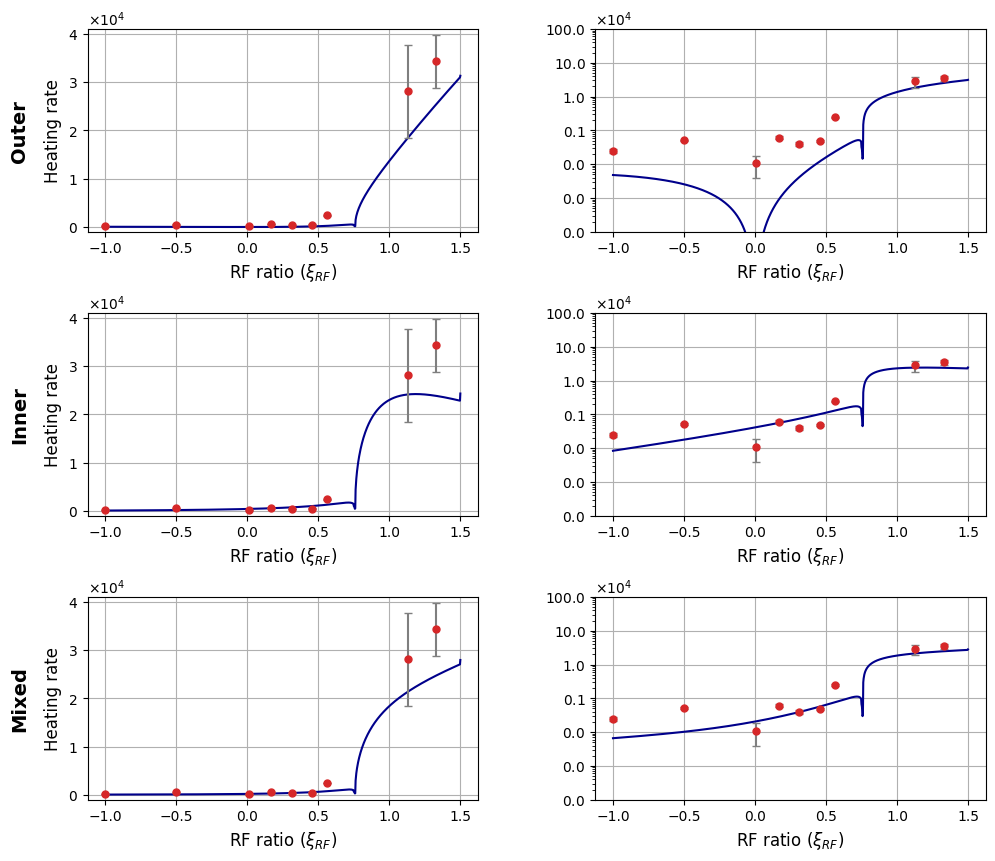

In [62]:
plot_all_heating_rates_rotated(csi_values, heating_rates_all[:, 30, :].T, csi_exp, h_exp, error_h_exp)